In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap

In [ ]:
def load_sentinel_bands(red_path, nir_path):
    with rasterio.open(red_path) as src:
        red = src.read(1).astype(float)
        profile = src.profile
        
    with rasterio.open(nir_path) as src:
        nir = src.read(1).astype(float)
    
    red[red == 0] = np.nan
    nir[nir == 0] = np.nan
    
    return red, nir, profile

def calculate_ndvi(red, nir):
    numerator = nir - red
    denominator = nir + red
    
    ndvi = np.where(denominator != 0, numerator / denominator, np.nan)
    
    ndvi = np.clip(ndvi, -1, 1)
    
    return ndvi

red_2020_path = "2020/2020-03-05-00:00_2020-03-05-23:59_Sentinel-2_L2A_B04_(Raw).tiff"  
nir_2020_path = "2020/2020-03-05-00:00_2020-03-05-23:59_Sentinel-2_L2A_B08_(Raw).tiff"  

red_2024_path = "2024/2024-01-09-00:00_2024-01-09-23:59_Sentinel-2_L2A_B04_(Raw).tiff"  
nir_2024_path = "2024/2024-01-09-00:00_2024-01-09-23:59_Sentinel-2_L2A_B08_(Raw).tiff"  

try:
    red_2020, nir_2020, profile_2020 = load_sentinel_bands(red_2020_path, nir_2020_path)
    ndvi_2020 = calculate_ndvi(red_2020, nir_2020)
    print(f"NDVI 2020 calculado. Shape: {ndvi_2020.shape}")
    print(f"Rango NDVI 2020: {np.nanmin(ndvi_2020):.3f} a {np.nanmax(ndvi_2020):.3f}")
except Exception as e:
    print(f"Error cargando datos 2020: {e}")



try:
    red_2024, nir_2024, profile_2024 = load_sentinel_bands(red_2024_path, nir_2024_path)
    ndvi_2024 = calculate_ndvi(red_2024, nir_2024)
    print(f"NDVI 2024 calculado. Shape: {ndvi_2024.shape}")
    print(f"Rango NDVI 2024: {np.nanmin(ndvi_2024):.3f} a {np.nanmax(ndvi_2024):.3f}")
except Exception as e:
    print(f"Error cargando datos 2024: {e}")




def detect_deforestation(ndvi_2020, ndvi_2024, threshold=-0.2):
    diferencia = ndvi_2024 - ndvi_2020
    
    mascara_deforestacion = np.where(diferencia < threshold, 1, 0)
    mascara_deforestacion = mascara_deforestacion.astype(float)
    mascara_deforestacion[np.isnan(diferencia)] = np.nan
    
    return diferencia, mascara_deforestacion

try:
    diferencia_ndvi, mascara_deforestacion = detect_deforestation(ndvi_2020, ndvi_2024)
    
    print(f"Análisis de cambios completado")
    print(f"Rango de diferencia NDVI: {np.nanmin(diferencia_ndvi):.3f} a {np.nanmax(diferencia_ndvi):.3f}")
    
    total_pixels = np.sum(~np.isnan(mascara_deforestacion))
    deforestacion_pixels = np.sum(mascara_deforestacion == 1)
    porcentaje_deforestacion = (deforestacion_pixels / total_pixels) * 100
    
    print(f"Píxeles totales analizados: {total_pixels:,}")
    print(f"Píxeles con deforestación: {deforestacion_pixels:,}")
    print(f"Porcentaje de deforestación: {porcentaje_deforestacion:.2f}%")
    
except Exception as e:
    print(f"Error en análisis de cambios: {e}")



NDVI 2020 calculado. Shape: (2202, 2500)
Rango NDVI 2020: -0.997 a 0.998
NDVI 2024 calculado. Shape: (2202, 2500)
Rango NDVI 2024: -0.997 a 0.998
Análisis de cambios completado
Rango de diferencia NDVI: -1.846 a 1.832
Píxeles totales analizados: 3,590,678
Píxeles con deforestación: 51,492
Porcentaje de deforestación: 1.43%


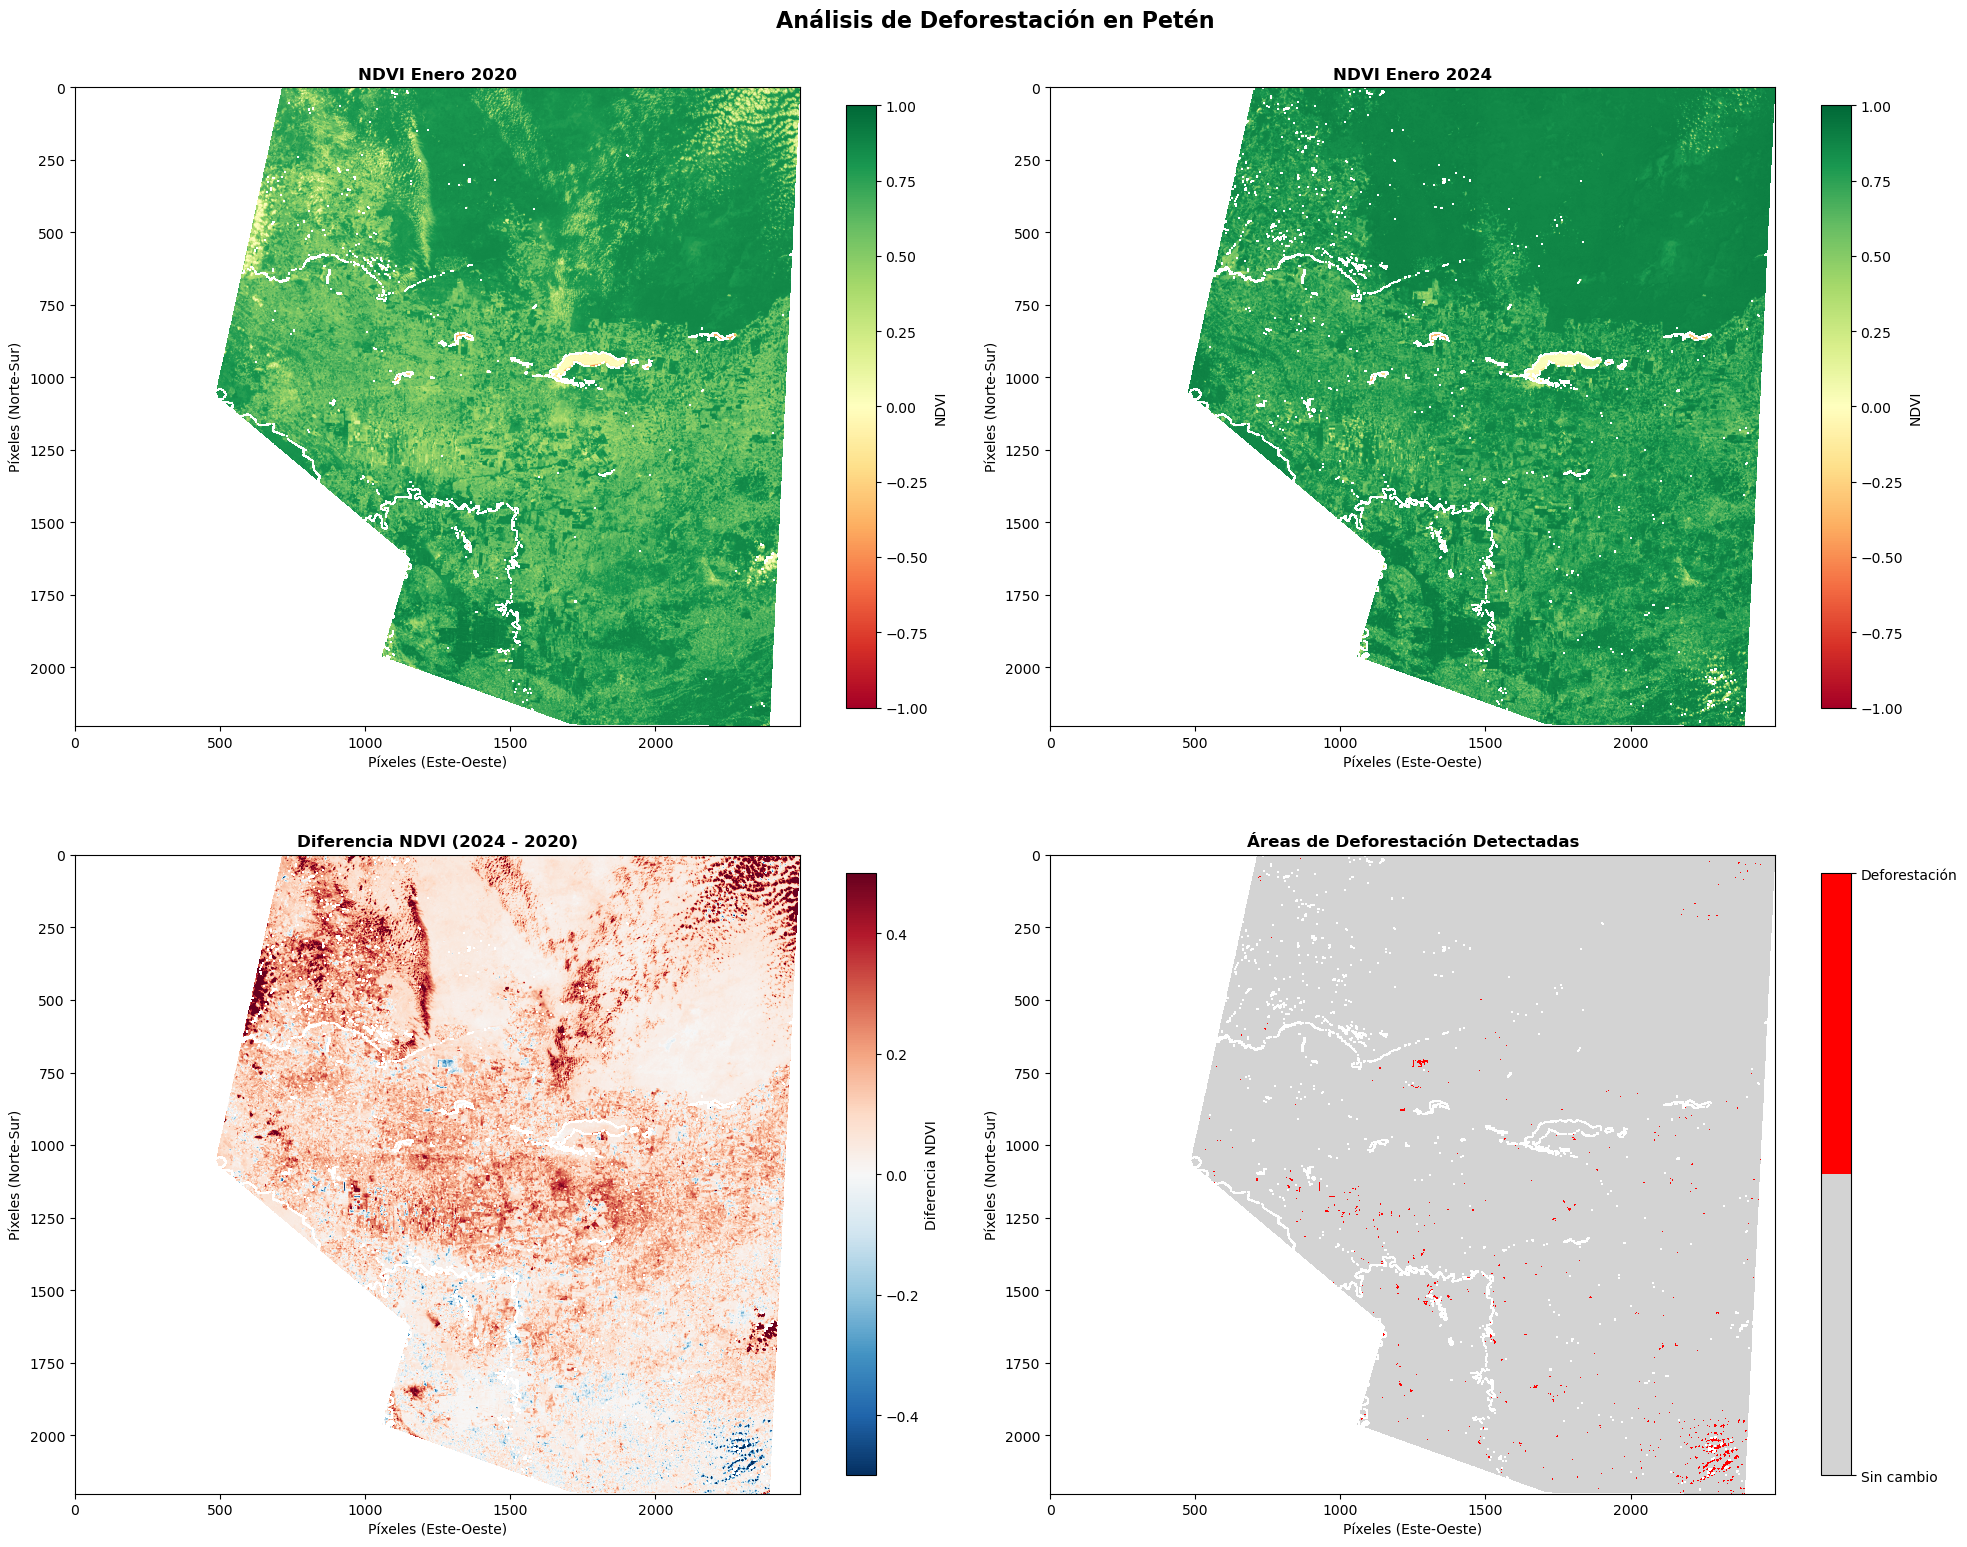

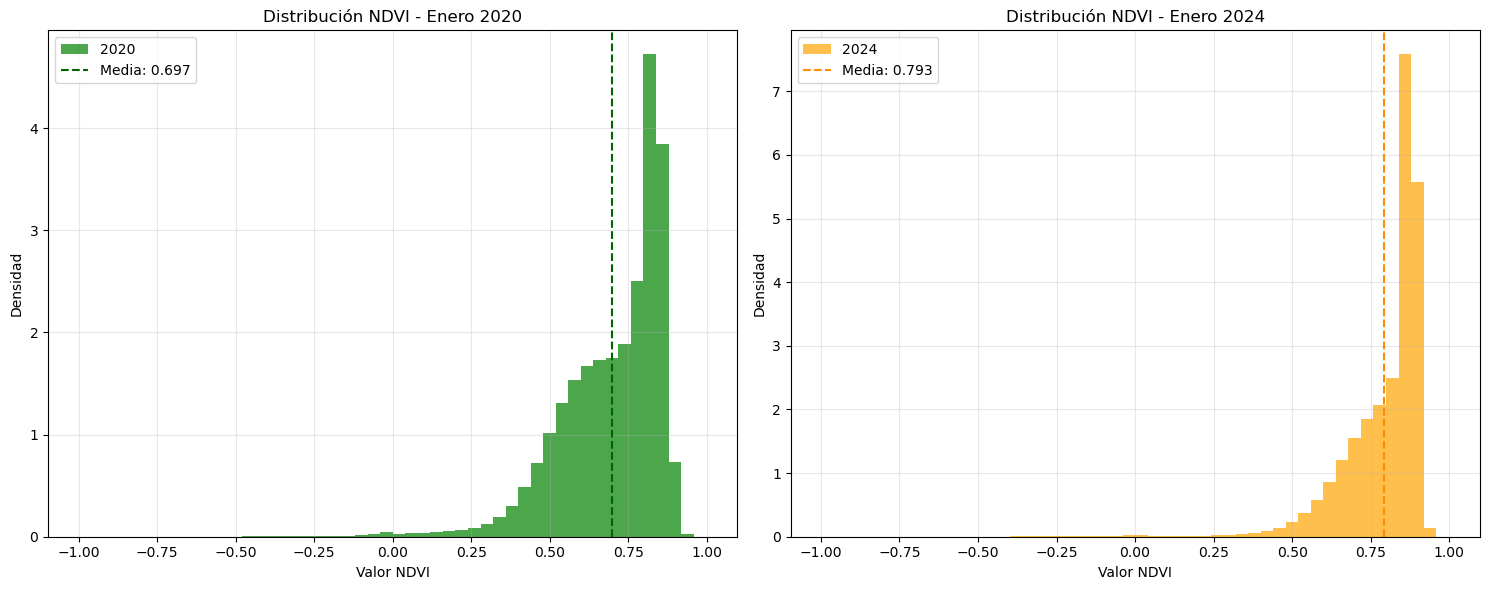

In [6]:
def plot_ndvi_comparison(ndvi_2020, ndvi_2024, diferencia, mascara_deforestacion):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Análisis de Deforestación en Petén', 
                 fontsize=16, fontweight='bold')
    
    ndvi_cmap = plt.cm.RdYlGn
    
    im1 = axes[0,0].imshow(ndvi_2020, cmap=ndvi_cmap, vmin=-1, vmax=1)
    axes[0,0].set_title('NDVI Enero 2020', fontweight='bold')
    axes[0,0].set_xlabel('Píxeles (Este-Oeste)')
    axes[0,0].set_ylabel('Píxeles (Norte-Sur)')
    plt.colorbar(im1, ax=axes[0,0], label='NDVI', shrink=0.8)
    
    im2 = axes[0,1].imshow(ndvi_2024, cmap=ndvi_cmap, vmin=-1, vmax=1)
    axes[0,1].set_title('NDVI Enero 2024', fontweight='bold')
    axes[0,1].set_xlabel('Píxeles (Este-Oeste)')
    axes[0,1].set_ylabel('Píxeles (Norte-Sur)')
    plt.colorbar(im2, ax=axes[0,1], label='NDVI', shrink=0.8)
    
    im3 = axes[1,0].imshow(diferencia, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    axes[1,0].set_title('Diferencia NDVI (2024 - 2020)', fontweight='bold')
    axes[1,0].set_xlabel('Píxeles (Este-Oeste)')
    axes[1,0].set_ylabel('Píxeles (Norte-Sur)')
    plt.colorbar(im3, ax=axes[1,0], label='Diferencia NDVI', shrink=0.8)
    
    colors = ['lightgray', 'red']
    deforest_cmap = ListedColormap(colors)
    
    im4 = axes[1,1].imshow(mascara_deforestacion, cmap=deforest_cmap, vmin=0, vmax=1)
    axes[1,1].set_title('Áreas de Deforestación Detectadas', fontweight='bold')
    axes[1,1].set_xlabel('Píxeles (Este-Oeste)')
    axes[1,1].set_ylabel('Píxeles (Norte-Sur)')
    
    cbar = plt.colorbar(im4, ax=axes[1,1], shrink=0.8, ticks=[0, 1])
    cbar.set_ticklabels(['Sin cambio', 'Deforestación'])
    
    plt.tight_layout()
    plt.show()

def plot_ndvi_histograms(ndvi_2020, ndvi_2024):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.hist(ndvi_2020[~np.isnan(ndvi_2020)].flatten(), bins=50, alpha=0.7, 
             color='green', label='2020', density=True)
    ax1.set_title('Distribución NDVI - Enero 2020')
    ax1.set_xlabel('Valor NDVI')
    ax1.set_ylabel('Densidad')
    ax1.grid(True, alpha=0.3)
    ax1.axvline(np.nanmean(ndvi_2020), color='darkgreen', linestyle='--', 
                label=f'Media: {np.nanmean(ndvi_2020):.3f}')
    ax1.legend()
    
    ax2.hist(ndvi_2024[~np.isnan(ndvi_2024)].flatten(), bins=50, alpha=0.7, 
             color='orange', label='2024', density=True)
    ax2.set_title('Distribución NDVI - Enero 2024')
    ax2.set_xlabel('Valor NDVI')
    ax2.set_ylabel('Densidad')
    ax2.grid(True, alpha=0.3)
    ax2.axvline(np.nanmean(ndvi_2024), color='darkorange', linestyle='--', 
                label=f'Media: {np.nanmean(ndvi_2024):.3f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


try:
    plot_ndvi_comparison(ndvi_2020, ndvi_2024, diferencia_ndvi, mascara_deforestacion)
    
    plot_ndvi_histograms(ndvi_2020, ndvi_2024)

    
except Exception as e:
    print(f" Error en visualizaciones: {e}")


def save_results(ndvi_2020, ndvi_2024, diferencia, mascara, profile, output_dir="resultados"):
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    
    profile_output = profile.copy()
    profile_output.update(count=1, dtype='float32')
    
    with rasterio.open(f'{output_dir}/ndvi_2020.tiff', 'w', **profile_output) as dst:
        dst.write(ndvi_2020.astype('float32'), 1)
    
    with rasterio.open(f'{output_dir}/ndvi_2024.tiff', 'w', **profile_output) as dst:
        dst.write(ndvi_2024.astype('float32'), 1)
    
    with rasterio.open(f'{output_dir}/diferencia_ndvi.tiff', 'w', **profile_output) as dst:
        dst.write(diferencia.astype('float32'), 1)
    
    with rasterio.open(f'{output_dir}/mascara_deforestacion.tiff', 'w', **profile_output) as dst:
        dst.write(mascara.astype('float32'), 1)
    

save_results(ndvi_2020, ndvi_2024, diferencia_ndvi, mascara_deforestacion, profile_2020)